# Analysis of individual events

This notebook extends the analysis presented in the *psf_analysis* notebook, for individual events. In that notebook, we performed a statistical comparison between the PSFs of the object and of a sample of normal stars.

The goal is to find evidence that the object as recorded was **not** caused by real point sources imaged by the telescope. In case we are unable to do that, further research would probably be warranted.

In this analysis, we go beyond what we did in notebook *psf_analysis*, specifically comparing the object's PSF with neighboring star's PSFs using:

- radial profiles
- profiles from image cuts

### Notebook *psf_analysis* must be run prior, so the proper product files are available for this analyisis.

In [1]:
import os, io
import cmath
import math

import numpy as np

from scipy.ndimage import map_coordinates

import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy.io.fits import Header, Card
from astropy.table import Table, join, hstack, vstack
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, concatenate
from astropy.stats import SigmaClip
from astropy.modeling import models, fitting

from photutils.background import Background2D, MedianBackground, ModeEstimatorBackground
from photutils.profiles import RadialProfile
from photutils.centroids import centroid_quadratic

from settings import get_parameters, current_dataset, fname
from library import clean_bad_fits, get_cutouts, plot_cutouts, remove_outsiders, make_sky_coords, fit_fwhm

## Functions

In [2]:
def _get_pixel_coords(table, source_id, cutout, wcs_original):
    '''
    Gets pixel coordinates for a source on a cutout.
    
    Parameters:

    table        - table with source data
    source_id    - the source ID that identifies the table row
    cutout       - image cutout
    wcs_original - the WCS of the original image where the cutout was taken from
    
    Returns:
    
    x,y coordinates in pixels
    '''
    # get 1-row table with desired source
    mask = table['source_id'] == source_id
    t1 = table[mask]

    # compute pixel coords in cutout 
    sky_coord = make_sky_coords(t1, wcs_original)
    cutout_coords = cutout.wcs.world_to_pixel(sky_coord)

    return cutout_coords[0][0], cutout_coords[1][0]

In [3]:
def _make_radial_profile(table, source_id, cutout, wcs_original, edge_radii):
    '''
    Makes a radial profile around position in image.
    
    Parameters:

    table        - table with X,Y pixel coordinates of object
    source_id    - the source ID that identifies the table row
    cutout       - image cutout
    wcs_original - the WCS of the original image where the cutout was taken from
    edge_radii   - array of radii defining the edges of the radial bins
    
    Returns:
    
    RadialProfile instance
    '''
    x, y = _get_pixel_coords(table, source_id, cutout, wcs_original)
    
    rp = RadialProfile(cutout.data, [x, y], edge_radii)
    
    return rp

In [4]:
def _make_profile(table, source_id, cutout, wcs_original, size, angle):
    '''
    Makes a profile for a given position, at a given angle.
    
    Parameters:

    table        - table with X,Y pixel coordinates of object
    source_id    - the source ID that identifies the table row
    cutout       - image cutout
    wcs_original - the WCS of the original image where the cutout was taken from
    size         - length in pixels
    angle        - orientation angle (0.0 is positive x; counter-clockwise)
    
    Returns:
    
    1-D numpy array with profile values
    '''
    x0, y0 = _get_pixel_coords(table, source_id, cutout, wcs_original)

    # use rectangle to get coordinates
    angle_radians = math.radians(angle)
    complex_coord = cmath.rect(size, angle_radians)
    xd = complex_coord.real
    yd = complex_coord.imag

    # path end points
    x1 = x0 + xd 
    y1 = y0 + yd 
    x2 = x0 - xd 
    y2 = y0 - yd 
    
    # Define path
    x_path = np.linspace(x1, x2, size * 2)
    y_path = np.linspace(y1, y2, size * 2)

    # Extract 1D data along path, order=1 is linear interpolation
    profile = map_coordinates(cutout.data, [y_path, x_path], order=1)
    
    return profile

In [5]:
def _make_labels(sid, source_id, label_flag):
    '''
    Encapsulates logic for handling plot labels and colors in profile plots
    '''
    color = 'blue'
    linewidth = 0.5
    if label_flag:
        label = 'field stars'
        label_flag = False
    else:
        label = None

    if sid == source_id:
        color = 'red'
        label = 'target object'
        linewidth = 1.0
        
    return label, color, linewidth, label_flag

In [6]:
def _plot_profile(ax, profile, positions, sid, source_id, label_flag, title):
    '''
    Code that is common to both plot types
    '''
    # normalize
    pr_max = np.max(profile)
    pr_min = np.min(profile)
    profile = (profile - pr_min) / (pr_max - pr_min)

    label, color, linewidth, label_flag = _make_labels(sid, source_id, label_flag)

    ax.plot(positions, profile, label=label, color=color, linewidth=linewidth)

    ax.set_xlabel("Position (pix)")
    ax.set_ylabel("Profile")
    ax.set_title(title)
    ax.legend()
    
    return label_flag

In [7]:
def plot_profiles(ax, table, source_id, cutout, wcs_original, size, angle, title):
    '''
    Plots profiles for all rows in a table.
    
    Parameters:
 
    ax           - the axis where to plot
    table        - table with X,Y pixel coordinates of object
    source_id    - the source ID that identifies the table row
    cutout       - image cutout
    wcs_original - the WCS of the original image where the cutout was taken from
    size         - length in pixels
    angle        - orientation angle (0.0 is positive x; counter-clockwise)
    title        - plot title
    '''
    label_flag = True

    for row in range(len(table)):
        sid = table['source_id'][row]
        profile = _make_profile(table, sid, cutout, wcs_original, size, angle)
        positions = np.arange(2*size)

        # change title to contain FWHM of target
        if sid == source_id:
            amp = np.max(profile) - np.min(profile)
            g_init = models.Gaussian1D(amplitude=amp, mean=positions[int(len(positions)/2)], stddev=8.)
            fit_g = fitting.LevMarLSQFitter()
            g = fit_g(g_init, positions, profile)
            
            fwhm = g.stddev.value
            str_two_decimals = f"{fwhm:.2f}"
            title = title + " - FWHM " + str_two_decimals
    
        label_flag = _plot_profile(ax, profile, positions, sid, source_id, label_flag, title)

    plt.tight_layout()

In [8]:
def plot_radial_profiles(ax, table, source_id, cutout, wcs_original, edge_radii, title):
    '''
    Plots radial profiles for all rows in a table.
    
    Parameters:

    ax           - the axis where to plot
    table        - table with X,Y pixel coordinates of object
    source_id    - the source ID that identifies the table row
    cutout       - image cutout
    wcs_original - the WCS of the original image where the cutout was taken from
    edge_radii   - array of radii defining the edges of the radial bins
    title        - plot title
    '''
    label_flag = True

    for row in range(len(table)):
        sid = table['source_id'][row]
        rp = _make_radial_profile(table, sid, cutout, wcs_original, edge_radii)
        
        positions = rp.radius
        profile = rp.profile
        
        label_flag = _plot_profile(ax, profile, positions, sid, source_id, label_flag, title)

    plt.tight_layout()

## Data definitions

In [9]:
par = get_parameters('9319,9320')
# source ID on first plate
source_id_1 = 40349380007658   # best event so far; cannot say it's not star-like
# source_id_1 = 40349380008146

# par = get_parameters('9318,9319')  # all have clearly non-starlike profiles
# source_id_1 = 40349360005499
# source_id_1 = 40349360002724
# source_id_1 = 40349360005208

# par = get_parameters('9317,9318')  # nothing here
# source_id_1 = 40349340048422   

# par = get_parameters('9315,9316')   # nothing here
# source_id_1 = 40349300064347   

# par = get_parameters('9323,9324')   # nothing here
# source_id_1 = 40349460001921   

# par = get_parameters('9325,9326')   # marginal candidate?
# source_id_1 = 40349500024760   

# par = get_parameters('9326,9327')   # nothing here
# source_id_1 = 40349520005014   
# source_id_1 =   40349520045496

# par = get_parameters('9327,9328')   # nothing here
# source_id_1 = 40349540056888   
# source_id_1 = 40349540056448   

# par = get_parameters('9346,9347')   # nothing here
# source_id_1 = 40349700020344   


## Data input

We need the processed tables created by script *find_mismatches* for both plates, as well as the plate scan itself.



In [10]:
# read tables

table_matched = Table.read(fname(par['table_matched']))
table_object  = Table.read(fname(par['table_psf_nonmatched']), format='fits')

print(len(table_matched), len(table_object))

13988 9


In [11]:
# read image scans (using just the first for now)

f_1 = fits.open(fname(par['image1']))
data_1 = f_1[0].data
header_1 = fits.getheader(fname(par['image1']))
wcs_1 = WCS(header_1)

f_2 = fits.open(fname(par['image2']))
data_2 = f_2[0].data
header_2 = fits.getheader(fname(par['image2']))
wcs_2 = WCS(header_2)

Set MJD-AVG to 35810.852292 from DATE-AVG.
Set MJD-END to 35810.857488 from DATE-END'. [astropy.wcs.wcs]
Set MJD-AVG to 35810.872176 from DATE-AVG.
Set MJD-END to 35810.877373 from DATE-END'. [astropy.wcs.wcs]


## Extract relevant parts of input data

Since we know the *source_id* identification of the object in the first plate, we can extracxt from the tables just the region around the object. In the same way, we can keep just the image cutout corresponding to that region. 

First, extract cutout from raw image. Then, use cutout corner's coordinates to filter out relevant rows from the tables.

Finally, filter out bad table entries using same criteria adopted in *find_mismatches* script.

In [12]:
# full side of square cutout

size = 3./60. * u.deg    # arcmin

In [13]:
# starting point is the row with source_id_1. We need the celestial coordinates.
mask = table_object['source_id'] == source_id_1
table_object = table_object[mask]

table_object

source_id,process_id_1,scan_id_1,plate_id_1,archive_id_1,solution_num,annular_bin_1,dist_center_1,dist_edge_1,sextractor_flags_1,model_prediction_1,ra_icrs,dec_icrs,ra_error,dec_error,gal_lon,gal_lat,ecl_lon,ecl_lat,x_sphere,y_sphere,z_sphere,healpix256,healpix1024,nn_dist,zenith_angle,airmass,natmag,natmag_error,bpmag,bpmag_error,rpmag,rpmag_error,natmag_plate,natmag_correction,natmag_residual,phot_range_flags,phot_calib_flags,color_term,cat_natmag,match_radius,gaiaedr3_id,gaiaedr3_gmag,gaiaedr3_bp_rp,gaiaedr3_dist,gaiaedr3_neighbors,timestamp_insert_1,timestamp_update_1,pos,process_id_2,scan_id_2,plate_id_2,archive_id_2,source_num,x_source,y_source,a_source,b_source,theta_source,erra_source,errb_source,errtheta_source,elongation,x_peak,y_peak,flag_usepsf,x_image,y_image,erra_image,errb_image,errtheta_image,x_psf,y_psf,erra_psf,errb_psf,errtheta_psf,mag_auto,magerr_auto,flux_auto,fluxerr_auto,mag_iso,magerr_iso,flux_iso,fluxerr_iso,flux_max,flux_radius,isoarea,sqrt_isoarea,background,sextractor_flags_2,dist_center_2,dist_edge_2,annular_bin_2,flag_rim,flag_negradius,flag_clean,model_prediction_2,timestamp_insert_2,timestamp_update_2,id,group_id,group_size,local_bkg,x_init,y_init,flux_init,fwhm_init,x_fit,y_fit,flux_fit,fwhm_fit,x_err,y_err,flux_err,fwhm_err,npixfit,qfit,cfit,flags
int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,bytes10,bytes10,bytes10,bytes10,bytes10,bytes10,float64,bytes15,bytes15,int64,int64,bytes9,bytes10,float64,bytes19,bytes4,bytes10,bytes12,int64,bytes29,bytes29,bytes42,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,bytes4,bytes4,bytes4,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,float64,bytes29,bytes29,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
40349380007658,34938,12209,9319,102,0,4,3248.3171,1061.8263,0,1.0,359.56717331456775,55.8796625754929,0.0968428,0.0834128,115.47776054780692,-6.220664977358579,30.123211279747515,49.57720175628767,0.5609168781911741,-0.004237387353368797,0.8278612808367626,226773,3628378,16.215902,17.767914,1.0499196,NULL,NULL,NULL,NULL,NULL,NULL,0.0,NULL,NULL,0,0,NULL,NULL,0.0,NULL,NULL,NULL,NULL,0,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.2756310564283 , 0.975284096845806)",34938,12209,9319,102,7658,5086.6753,1061.8238552112286,2.3742547,2.2668324,-49.867508,0.022372551,0.021500487,-72.44109,1.0473888,5087,1062,0,5086.6753,1061.8263,0.022372551,0.021500487,-72.44109,NULL,NULL,NULL,NULL,NULL,9.33182,0.011810238,1850428.6,20123.39,9.302416,0.007824958,1901226.4,13698.91,38214.902,2.9795022,89,9.433981,2401.1907,0,3248.3171,1061.8263,4,0,0,1,1.0,2022-06-13 05:05:13.513042+00,2022-06-13 05:05:13.513042+00,23,23,1,0.0,5086.6753,1061.8238552112286,767402.0,6.0,5085.714813397793,1060.7941446180912,1968451.3567549216,6.095988620201128,0.04570986150201917,0.045249058000968435,34180.92995100392,0.07607204918336294,961,1.038378099585041,-0.0009020770638366653,0


In [14]:
# cutout around target's celestial coordinates
ra  = (table_object['ra_icrs'])
dec = (table_object['dec_icrs'])

target_coords = SkyCoord(ra=ra, dec=dec, unit='deg')

cutout_1, no_need = get_cutouts(fname(par['image1']), fname(par['image2']), target_coords, size)

Set MJD-AVG to 35810.872176 from DATE-AVG.
Set MJD-END to 35810.877373 from DATE-END'. [astropy.wcs.wcs]


In [15]:
# filter out rows that fall outside the cutout footprint

table_matched_neighborhood = remove_outsiders(cutout_1.data, cutout_1.wcs, table_matched, wcs_table=wcs_1)

print(len(table_matched_neighborhood))

12


In [16]:
table_matched_neighborhood

source_id,process_id_1,scan_id_1,plate_id_1,archive_id_1,solution_num,annular_bin_1,dist_center_1,dist_edge_1,sextractor_flags_1,model_prediction_1,ra_icrs,dec_icrs,ra_error,dec_error,gal_lon,gal_lat,ecl_lon,ecl_lat,x_sphere,y_sphere,z_sphere,healpix256,healpix1024,nn_dist,zenith_angle,airmass,natmag,natmag_error,bpmag,bpmag_error,rpmag,rpmag_error,natmag_plate,natmag_correction,natmag_residual,phot_range_flags,phot_calib_flags,color_term,cat_natmag,match_radius,gaiaedr3_id,gaiaedr3_gmag,gaiaedr3_bp_rp,gaiaedr3_dist,gaiaedr3_neighbors,timestamp_insert_1,timestamp_update_1,pos,process_id_2,scan_id_2,plate_id_2,archive_id_2,source_num,x_source,y_source,a_source,b_source,theta_source,erra_source,errb_source,errtheta_source,elongation,x_peak,y_peak,flag_usepsf,x_image,y_image,erra_image,errb_image,errtheta_image,x_psf,y_psf,erra_psf,errb_psf,errtheta_psf,mag_auto,magerr_auto,flux_auto,fluxerr_auto,mag_iso,magerr_iso,flux_iso,fluxerr_iso,flux_max,flux_radius,isoarea,sqrt_isoarea,background,sextractor_flags_2,dist_center_2,dist_edge_2,annular_bin_2,flag_rim,flag_negradius,flag_clean,model_prediction_2,timestamp_insert_2,timestamp_update_2
int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,bytes10,bytes10,bytes10,bytes10,bytes10,bytes10,float64,bytes15,bytes15,int64,int64,bytes9,bytes10,float64,bytes19,bytes4,bytes10,bytes12,int64,bytes29,bytes29,bytes42,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,bytes4,bytes4,bytes4,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,float64,bytes29,bytes29
40349380006868,34938,12209,9319,102,1,4,3343.4597,976.5777,0,1.0,359.59384694770955,55.85796294384656,0.0968428,0.0834128,115.48800524977538,-6.244978498270294,30.12092063964743,49.55088175394039,0.5612322778974411,-0.003978478394189124,0.8276487793476871,226773,3628378,28.042532,17.75524,1.0498455,16.688221,0.339642,16.484768,0.33966333,15.340598,0.33966333,16.622728,0.06549258,0.04011917,0,1,1.1778167,16.72834,0.6390662,1994722042226817152,NULL,1.14417,0.39034495,1,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.27609659915009 , 0.974905366827107)",34938,12209,9319,102,6868,5026.7695,976.549476474044,2.5347855,2.194908,-12.798996,0.041797757,0.03587595,-7.651688,1.1548482,5026,977,0,5026.7695,976.5777,0.041797757,0.03587595,-7.651688,NULL,NULL,NULL,NULL,NULL,9.783354,0.018289534,1220838.8,20560.379,10.02324,0.014711099,978822.44,13259.258,21525.713,3.5429676,84,9.165152,3367.5718,0,3343.4597,976.5777,4,0,0,1,1.0,2022-06-13 05:05:13.513042+00,2022-06-13 05:05:13.513042+00
40349380007060,34938,12209,9319,102,1,4,3328.0408,999.46533,0,1.0,359.60946872696394,55.86363187679234,0.0968428,0.0834128,115.49780757922575,-6.241230403785062,30.136954284740913,49.5499853642615,0.5611514520811289,-0.003824899261899159,0.8277043058803529,226773,3628376,11.693135,17.74594,1.0497911,16.861448,0.32189417,16.65624,0.32191706,15.502201,0.32191706,16.824558,0.03689026,0.2650528,0,1,1.1778167,17.126501,0.6390662,1994721320672309504,NULL,1.15404,0.26546308,1,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.2763692506331 , 0.975004308372086)",34938,12209,9319,102,7060,4992.3994,999.456629707341,2.2247472,1.8369795,-83.27565,0.046300028,0.037470732,-86.463165,1.2110898,4992,999,0,4992.3994,999.46533,0.046300028,0.037470732,-86.463165,NULL,NULL,NULL,NULL,NULL,9.911879,0.030052993,1084547.9,30012.809,10.453666,0.018398844,658466.6,11155.64,18782.252,3.8026118,61,7.81025,3319.254,0,3328.0408,999.46533,4,0,0,1,1.0,2022-06-13 05:05:13.513042+00,2022-06-13 05:05:13.513042+00
40349380007256,34938,12209,9319,102,1,4,3286.0596,1017.1469,3,1.0,359.5512722661334,55.868494670232174,0.0

In [17]:
# arrays with celestial coordinates for displaying on the image
sc_matched = make_sky_coords(table_matched_neighborhood, wcs_1)
sc_object  = make_sky_coords(table_object, wcs_1)

coords = concatenate([sc_matched, sc_object])

cutout shape: (197, 198) px


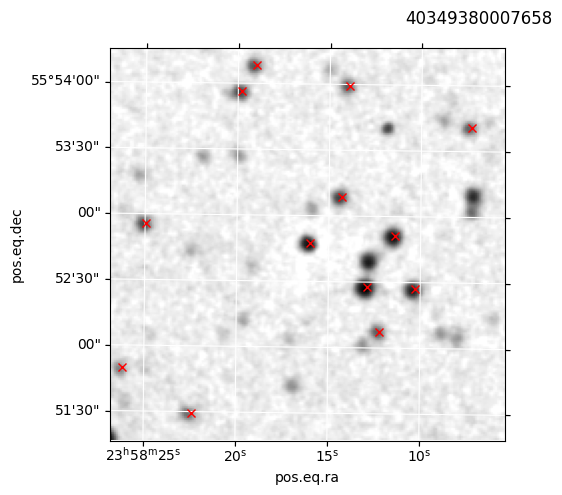

In [18]:
plot_cutouts(cutout_1, None, coords, str(source_id_1), 
             invert_east=par['invert_east'], invert_north=par['invert_north'])

### Invert and subtract background

In [19]:
# photographic images are inverted ("negative"). Make result a float array for convenience.
cutout_1.data = 65535. - cutout_1.data

# subtract background
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg_1 = Background2D(cutout_1.data, 40, filter_size=3, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

cutout_1.data = cutout_1.data - bkg_1.background

## Radial profiles

We compute radial profiles for all stars in the field, and the target object.

In [20]:
# radii where to compute profiles

edge_radii = np.arange(15)

In [21]:
# the profile ploting functions neeed all profiles packed in a single table. They
# disentangle them based on source ID.

table_all = vstack([table_matched_neighborhood, table_object])

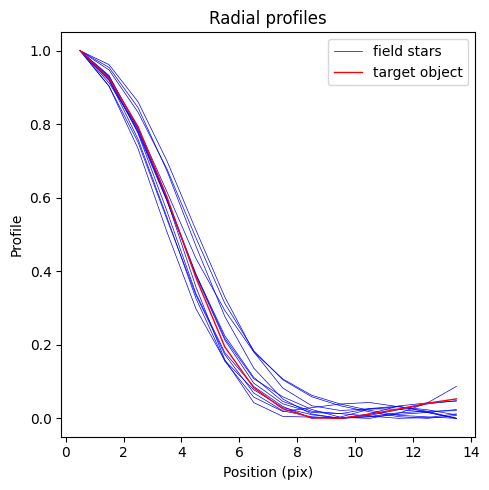

In [22]:
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)

plot_radial_profiles(ax, table_all, source_id_1, cutout_1, wcs_1, edge_radii, 'Radial profiles')

### Notes:

## Cutout profiles

Here we compute 1-D profiles across all stars in the field, and the target object, made at different angles (angle goes counter-clockwise: 0 deg is +x, 90 deg is +y).

These profiles might help in pinpointing deviations from non-circularity.

/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_71174/1098497209.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


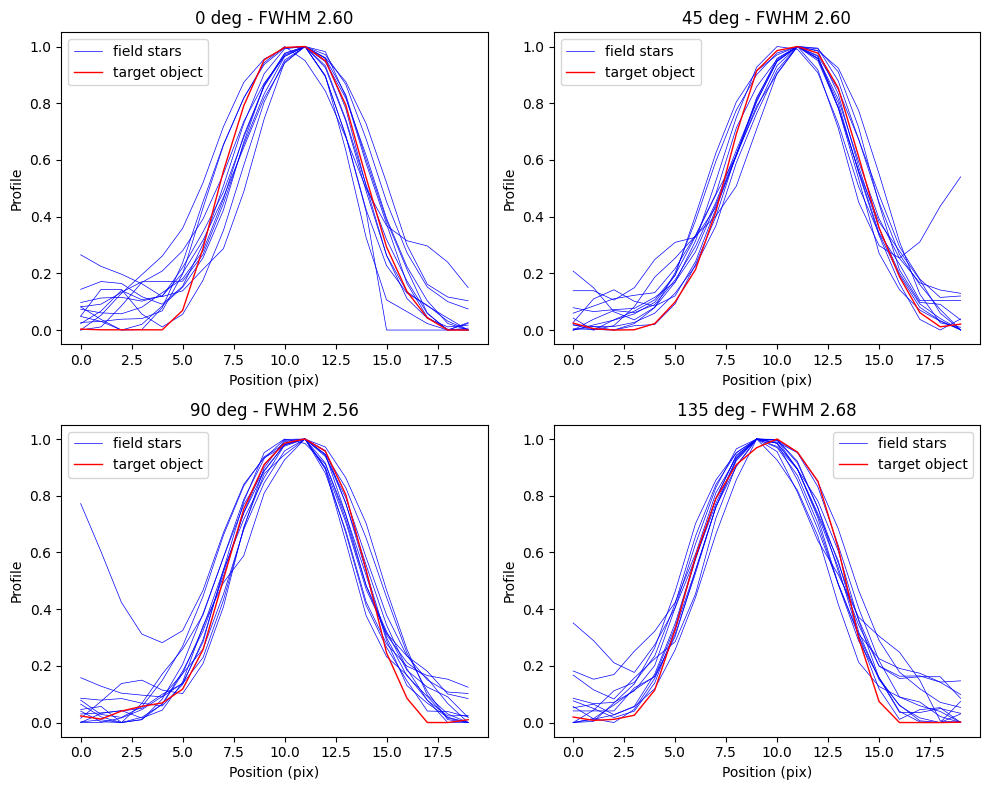

In [23]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

lenght = 10
angle = 0
title_suffix = str(angle) + ' deg'
plot_profiles(ax1, table_all, source_id_1, cutout_1, wcs_1, lenght,  angle,  title_suffix)

angle = 45
title_suffix = str(angle) + ' deg'
plot_profiles(ax2, table_all, source_id_1, cutout_1, wcs_1, lenght, angle, title_suffix)

angle = 90
title_suffix = str(angle) + ' deg'
plot_profiles(ax3, table_all, source_id_1, cutout_1, wcs_1, lenght, angle, title_suffix)

angle = 135
title_suffix = str(angle) + ' deg'
plot_profiles(ax4, table_all, source_id_1, cutout_1, wcs_1, lenght, angle, title_suffix)


### Notes:

